# Setup

In [1]:
!pip install tensorflow==2.9.1 numpy==1.23.1 Pillow==9.2.0 importlib-metadata==4.11.3 matplotlib==3.5.2 scikit-learn==1.1.1 tensorboard==2.9.1 jupyter==1.0.0 ipykernel==6.9.1 seaborn==0.13.2

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.2/162.2 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 6.2 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of jupyter-console to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.7/511.7 MB 2.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 89.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 88.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 95.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.2/31.2 MB 45.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 94.2 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 14.2 MB/s eta 0:00:00
   ━━━━

In [ ]:
import os
import scipy
import importlib
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from scipy.sparse.linalg import gmres
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


# import matrixlib
import matrixlib.io
import matrixlib.util
import matrixlib.plot
import matrixlib.generate
from matrixlib.metadata import MatrixMetadata

#import CNN
import CNN.models
import CNN.training
import CNN.evaluation

# import solvers
import solvers.gmres


# Check wd
current_base_path = os.getcwd()
print(f"Path to current working directory: {current_base_path}")

# Generate Synthetic Data
Generate a set of `n` square symmetrical and positive semi matrices of dimensions `MATRIX_DIM` to RAM.

## Define Constants
The following constants are used throughout the rest of the notebook.

In [ ]:
MATRIX_DIM = 64
NUMBER_OF_MATRICES = 1000

AVERAGE_BLOCK_SIZE = 10
BLOCK_SIZE_STD_DEV = 0.66

NOISE_BACKGROUND_DENSITY_RANGE = (0.3, 0.5)
NOISE_BACKGROUND_VALUE_RANGE = (0.0, 0.5)

NOISE_BLOCK_GAP_CHANCE = 0.5
NOISE_BLOCK_SIZE_RANGE = (3, 32)
NOISE_BLOCK_DENSITY_RANGE = (0.3, 0.5)
NOISE_BLOCK_VALUE_RANGE = (0.0, 1.0)

TRUE_BLOCK_GAP_CHANCE = 0.0
TRUE_BLOCK_SIZE_RANGE = (2, 32)
TRUE_BLOCK_DENSITY_RANGE = (0.5, 0.7)
TRUE_BLOCK_VALUE_RANGE = (0.0, 1.0)

DIAGONAL_BAND_RADIUS = 10
DIAGONAL_BAND_DIMENSION = 2 * DIAGONAL_BAND_RADIUS + 1

RNG_SEED = 42

In [ ]:
def generate_matrices(number_of_matrices: int, dimension: int) -> (np.ndarray, np.ndarray):
    generated_metadata: MatrixMetadata = MatrixMetadata(NUMBER_OF_MATRICES, MATRIX_DIM)
    generated_matrices: np.array = matrixlib.generate.__init_zero_matrices(number_of_matrices, dimension)

    # add background noise to the generated matrices
    matrixlib.generate.add_noise(
        generated_matrices,
        generated_metadata.noise_background_density,
        NOISE_BACKGROUND_DENSITY_RANGE,
        NOISE_BACKGROUND_VALUE_RANGE
    )

    # add noise blocks with higher values to the diagonal of the matrix
    noise_block_sizes = matrixlib.generate.add_blocks(
        generated_matrices,
        None,
        generated_metadata.noise_block_density,
        NOISE_BLOCK_DENSITY_RANGE,
        NOISE_BLOCK_VALUE_RANGE,
        NOISE_BLOCK_SIZE_RANGE,
        NOISE_BLOCK_GAP_CHANCE,
        AVERAGE_BLOCK_SIZE,
        BLOCK_SIZE_STD_DEV,
    )

    # add 'real' blocks to the diagonal of the matrix without gaps
    true_block_sizes = matrixlib.generate.add_blocks(
        generated_matrices,
        generated_metadata.block_starts,
        generated_metadata.true_block_density,
        TRUE_BLOCK_DENSITY_RANGE,
        TRUE_BLOCK_VALUE_RANGE,
        TRUE_BLOCK_SIZE_RANGE,
        TRUE_BLOCK_GAP_CHANCE,
        AVERAGE_BLOCK_SIZE,
        BLOCK_SIZE_STD_DEV,
    )

    return generated_matrices, generated_metadata

def matrices_to_diagonal_bands(matrices: np.ndarray, band_radius: int) -> np.ndarray:
    number_of_matrices, dim, _ = matrices.shape
    band_results = np.zeros((number_of_matrices, dim, band_radius * 2 + 1))

    for i in range(number_of_matrices):
        band_results[i] = matrixlib.util.narrow_to_band(matrices[i], band_radius, padding_value = 0)
    
    return band_results

In [ ]:
generated_matrices, metadata = generate_matrices(NUMBER_OF_MATRICES, MATRIX_DIM)
matrices = generated_matrices.reshape(NUMBER_OF_MATRICES, MATRIX_DIM, MATRIX_DIM, 1)
labels = metadata.block_starts
# bands = matrices_to_diagonal_bands(matrices, DIAGONAL_BAND_RADIUS)

# print(matrices.shape)
# print(bands.shape)

# Create dataset from matrices and labels
dataset = tf.data.Dataset.from_tensor_slices((matrices, labels))
# dataset = tf.data.Dataset.from_tensor_slices((bands, labels))

# Split the dataset
train_size = int(0.8 * NUMBER_OF_MATRICES)
val_size = int(0.1 * NUMBER_OF_MATRICES)
test_size = NUMBER_OF_MATRICES - train_size - val_size

train_dataset = dataset.take(train_size).shuffle(buffer_size=10)
val_dataset = dataset.skip(train_size).take(val_size)
test_dataset = dataset.skip(train_size + val_size)

print(f"Train size: {train_size}, Val size: {val_size}, Test size: {test_size}")


In [ ]:
# Verfiy Shape
print(train_dataset)
print(val_dataset)
print(test_dataset)

# for element in val_dataset:
#    print(element)

# Training

In [ ]:
# reload the library when changes were made to it
importlib.reload(matrixlib.io)
importlib.reload(matrixlib.util)
importlib.reload(matrixlib.plot)
importlib.reload(matrixlib.generate)
#importlib.reload(CNN.dataloader)

importlib.reload(CNN.models)
importlib.reload(CNN.training)
importlib.reload(CNN.evaluation)
importlib.reload(matrixlib.generate)

# importlib.reload(solvers.gmres)
# importlib.reload(solvers.blockjacobi)

In [53]:
# Define parameters
loss_fn = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.000005)
num_epochs = 50
log_dir = "runs/matrix_cnn_experiment"

# Check log files
if not os.path.exists(log_dir):
    os.makedirs(log_dir)
print("Files in log directory:", os.listdir(log_dir))

# Compile Model
# model = CNN.models.Baseline(input_shape=(MATRIX_DIM, MATRIX_DIM, 1))
model = CNN.models.Baseline(input_shape=(MATRIX_DIM, MATRIX_DIM, 1))
model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=['accuracy'])

Files in log directory: ['events.out.tfevents.1718292438.codespaces-54156f.2041.1.v2', 'events.out.tfevents.1718060982.codespaces-54156f.7101.0.v2', 'best_model_checkpoint.data-00000-of-00001', 'events.out.tfevents.1718032116.codespaces-54156f.14560.2.v2', 'best_model_weights.tf.data-00000-of-00001', 'events.out.tfevents.1718033196.codespaces-54156f.22401.3.v2', 'events.out.tfevents.1718032643.codespaces-54156f.14560.4.v2', 'events.out.tfevents.1718292853.codespaces-54156f.13603.0.v2', 'events.out.tfevents.1718292378.codespaces-54156f.2041.0.v2', 'events.out.tfevents.1718031378.codespaces-54156f.14560.0.v2', 'events.out.tfevents.1718100911.codespaces-54156f.5357.0.v2', 'events.out.tfevents.1718061692.codespaces-54156f.1665.0.v2', 'events.out.tfevents.1718293244.codespaces-54156f.13603.1.v2', 'events.out.tfevents.1718032710.codespaces-54156f.22401.1.v2', 'events.out.tfevents.1718032690.codespaces-54156f.22401.0.v2', 'events.out.tfevents.1718031281.codespaces-54156f.11365.0.v2', 'events.

In [54]:
# Start Training Loop
trained_model, train_losses, val_losses = CNN.training.train_model(
    model=model,
    train_dataset=train_dataset.batch(4),  # Adjust when connected to vm
    val_dataset=val_dataset.batch(4),
    loss_fn=loss_fn, 
    optimizer=optimizer,
    num_epochs=num_epochs,
    log_dir=log_dir
)

Epoch 1/50
Train Loss: 1.3471 | Validation Loss: 1.2587
Epoch 2/50
Train Loss: 1.1871 | Validation Loss: 1.1790
Epoch 3/50
Train Loss: 1.0129 | Validation Loss: 1.1179
Epoch 4/50
Train Loss: 0.8237 | Validation Loss: 1.0837
Epoch 5/50
Train Loss: 0.6737 | Validation Loss: 1.0598
Epoch 6/50
Train Loss: 0.5646 | Validation Loss: 1.0424
Epoch 7/50
Train Loss: 0.4841 | Validation Loss: 1.0342
Epoch 8/50
Train Loss: 0.4229 | Validation Loss: 1.0291
Epoch 9/50
Train Loss: 0.3763 | Validation Loss: 1.0303
Epoch 10/50
Train Loss: 0.3383 | Validation Loss: 1.0291
Epoch 11/50
Train Loss: 0.3090 | Validation Loss: 1.0318
Epoch 12/50
Train Loss: 0.2859 | Validation Loss: 1.0363
Epoch 13/50
Train Loss: 0.2660 | Validation Loss: 1.0393
Epoch 14/50
Train Loss: 0.2483 | Validation Loss: 1.0485
Epoch 15/50
Train Loss: 0.2338 | Validation Loss: 1.0583
Epoch 16/50
Train Loss: 0.2223 | Validation Loss: 1.0612
Epoch 17/50
Train Loss: 0.2108 | Validation Loss: 1.0661
Epoch 18/50
Train Loss: 0.2025 | Validat

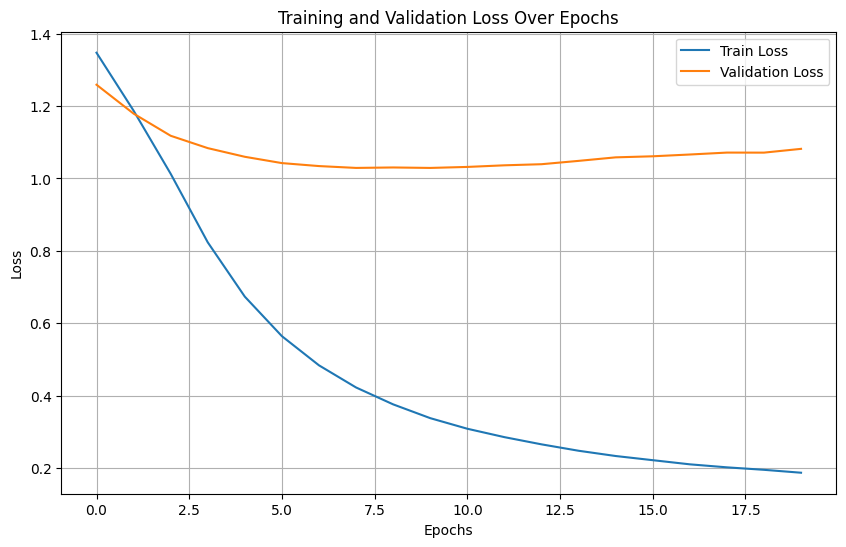

In [55]:
# Plot losses
def plot_losses(train_losses, val_losses):
    """
    Plots the training and validation losses.

    Args:
        train_losses (list of float): List of training losses per epoch.
        val_losses (list of float): List of validation losses per epoch.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_losses(train_losses, val_losses)

# Evaluation

In [59]:
# Restore the model weights from the checkpoint
trained_model = CNN.models.Baseline(input_shape=(MATRIX_DIM, MATRIX_DIM, 1))
# trained_model = CNN.models.Baseline(input_shape=(MATRIX_DIM, DIAGONAL_BAND_DIMENSION, 1))

checkpoint_path = "runs/matrix_cnn_experiment/best_model_checkpoint"
checkpoint = tf.train.Checkpoint(model=trained_model)
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_path)).expect_partial()

In [60]:
# Evaluate the model on the test set
evaluation_results = CNN.evaluation.evaluate_model(
    model=trained_model,
    test_dataset=test_dataset.batch(4),
    loss_fn=loss_fn
)

: 

# Prediction

In [43]:
# Extract test matrices and labels from dataset
test_matrices = generated_matrices[train_size + val_size:]
test_labels = metadata.block_starts[train_size + val_size:]

# Make Predictions
test_predictions = trained_model.predict(test_dataset.batch(8))

# Convert to Binary
threshold = 0.5
binary_predictions = (test_predictions >= threshold).astype(int)

# Calculate Metrics
overall_accuracy = (binary_predictions == test_labels).mean()
print("Overall Accuracy:")
print(overall_accuracy)

13/13 [==============================] - 3s 239ms/step
Overall Accuracy:
0.4790625


# Create Block Jacobi Preconditioner

In [ ]:
print(test_matrices.shape)
print(binary_predictions.shape)

In [52]:
def block_jacobi_preconditioner_from_predictions(A, binary_predictions, regularization_factor=1e-10):
    """
    Calculates the block Jacobi preconditioner for each 2D matrix in a 3D array using binary predictions for block starts.

    Args:
        A: NumPy array of shape (n, m, m) representing n square matrices of size m x m.
        binary_predictions: NumPy array of shape (n, m) where each row indicates block starts with 1s.

    Returns:
        A NumPy array of the same shape as A representing the block diagonal preconditioner for each 2D matrix.
    """
    n, m, _ = A.shape
    
    # Initialize the preconditioner array
    prec = np.zeros_like(A)
    
    for k in range(n):
        # Find block start indices from binary predictions
        block_starts = np.where(binary_predictions[k] == 1)[0]
        
        # Ensure to include the end of the matrix as a block end
        block_starts = np.append(block_starts, m)
        
        # Extract diagonal blocks
        blocks = []
        for i in range(len(block_starts) - 1):
            start = block_starts[i]
            end = block_starts[i + 1]
            blocks.append(A[k, start:end, start:end])
        
        # Invert diagonal blocks if they are invertible
        inv_blocks = []
        for block in blocks:
            print("Block:\n", block)
            condition_number_before = check_condition_number(block)
            print(f"Condition number before regularization: {condition_number_before}")
            try:
                # Add regularization to the diagonal
                reg_block = block + np.eye(block.shape[0]) * regularization_factor
                inv_block = np.linalg.inv(reg_block)
                condition_number_after = check_condition_number(inv_block)
                print(f"Condition number after regularization and inversion: {condition_number_after}")
            except np.linalg.LinAlgError:
                # Use pseudoinverse if the block is singular
                print("Using pseudoinverse due to singularity.")
                inv_block = np.linalg.pinv(block)
                condition_number_after = check_condition_number(inv_block)
                print(f"Condition number after pseudoinversion: {condition_number_after}")
            
            if not np.isfinite(condition_number_after) or condition_number_after == 1.0:
                print("Warning: Condition number of inverted block is not finite or is 1.0.")
            
            inv_blocks.append(inv_block)
        
        # Create block diagonal matrix for the k-th matrix
        for i, block in enumerate(inv_blocks):
            start = block_starts[i]
            end = block_starts[i + 1]
            prec[k, start:end, start:end] = block
    
    return prec

In [45]:
# Create preconditioner
prec = block_jacobi_preconditioner_from_predictions(test_matrices, test_labels)

print("Original Matrix A (first instance):")
print(test_matrices[0])
print("\nBlock Jacobi Preconditioner (first instance):")
print(prec[0])

Original Matrix A (first instance):
[[0.21908919 0.43510673 0.15531831 ... 0.11198236 0.         0.        ]
 [0.43510673 0.63951518 0.31002677 ... 0.         0.29920132 0.1464676 ]
 [0.15531831 0.31002677 0.         ... 0.16201909 0.         0.        ]
 ...
 [0.11198236 0.         0.16201909 ... 0.55464407 0.6560577  0.21919565]
 [0.         0.29920132 0.         ... 0.6560577  0.34764876 0.41355301]
 [0.         0.1464676  0.         ... 0.21919565 0.41355301 0.        ]]

Block Jacobi Preconditioner (first instance):
[[ -2.3081563    0.31265559   2.00463186 ...   0.           0.
    0.        ]
 [  0.31265559   1.1119732   -1.17481058 ...   0.           0.
    0.        ]
 [  2.00463186  -1.17481058  -0.86692244 ...   0.           0.
    0.        ]
 ...
 [  0.           0.           0.         ...   4.39202834   1.24274475
   12.46422088]
 [  0.           0.           0.         ...   1.24274475   0.35164037
   11.64743965]
 [  0.           0.           0.         ...  12.46422088

# GMRES Solver

## Check Condition Number before Preconditioning

In [ ]:
print(test_labels.shape)
print(test_labels[0])

In [46]:
def check_condition_number(matrix):
    try:
        condition_number = np.linalg.cond(matrix)
    except np.linalg.LinAlgError:
        condition_number = float('inf')
    return condition_number

print(check_condition_number(test_matrices[0]))
print(check_condition_number(prec[0]))


1419.2131806189145
1091.0886330939938


In [47]:
import scipy.sparse.linalg as spla

# Define the GMRES solver function
def gmres_solver(A, b, tol=1e-8, maxiter=1000, M=None):
    """
    Solves Ax = b using the GMRES solver.
    
    Args:
        A: The matrix A.
        b: The right-hand side vector b.
        tol: The tolerance for convergence.
        maxiter: The maximum number of iterations.
        M: The preconditioner matrix.
    
    Returns:
        x: The solution vector.
        info: The convergence information.
    """
    x, info = spla.gmres(A, b, tol=tol, maxiter=maxiter, M=M)
    return x, info


n = test_matrices.shape[0]
A = test_matrices[0]

In [48]:
# Convert test_labels to integer indices
block_starts = np.where(test_labels[0] == 1)[0]

# Check condition numbers
for i, matrix in enumerate(test_matrices):
    condition_number = check_condition_number(matrix)
    print(f"Condition number of matrix {i}: {condition_number}")
    block_starts = np.where(binary_predictions[i] == 1)[0]
    block_starts = np.append(block_starts, matrix.shape[0])
    for j in range(len(block_starts) - 1):
        start = block_starts[j]
        end = block_starts[j + 1]
        block = matrix[start:end, start:end]
        block_condition_number = check_condition_number(block)
        print(f"Condition number of block {j} of matrix {i}: {block_condition_number}")
        prec_block = prec[i, start:end, start:end]
        prec_block_condition_number = check_condition_number(prec_block)
        print(f"Condition number of preconditioner block {j} of matrix {i}: {prec_block_condition_number}")

print("Original Matrix A (first instance):")
print(test_matrices[0])
print("\nBlock Jacobi Preconditioner (first instance):")
print(prec[0])

Condition number of matrix 0: 1419.2131806189145
Condition number of block 0 of matrix 0: 1.0
Condition number of preconditioner block 0 of matrix 0: 1.0
Condition number of block 1 of matrix 0: 1.0
Condition number of preconditioner block 1 of matrix 0: 1.0
Condition number of block 2 of matrix 0: inf
Condition number of preconditioner block 2 of matrix 0: 1.0
Condition number of block 3 of matrix 0: 4.167375193338026
Condition number of preconditioner block 3 of matrix 0: 15.501290739223847
Condition number of block 4 of matrix 0: 15.214412982933927
Condition number of preconditioner block 4 of matrix 0: 9.139703670551874
Condition number of block 5 of matrix 0: 1.0
Condition number of preconditioner block 5 of matrix 0: 1.0
Condition number of block 6 of matrix 0: 4.395037642197664
Condition number of preconditioner block 6 of matrix 0: 8.30868881778632
Condition number of block 7 of matrix 0: 11.59289618377031
Condition number of preconditioner block 7 of matrix 0: 5.62677393379318

In [50]:
# Run GMRES solver on unconditioned matrices
from scipy.sparse.linalg import gmres

# Define parameters
maxit = 1000000
tol = 1e-5

solutions_no_preconditioner = []  # List to store solution vectors for all matrices


for i, matrix in enumerate(test_matrices):
    # Convert matrix to sparse format
    A_sparse = scipy.sparse.csr_matrix(matrix)

    # Define right-hand side as a vector of ones
    b = np.ones(matrix.shape[0])

    # Extract the corresponding preconditioner for this matrix
    preconditioner_matrix = scipy.sparse.csr_matrix(prec[i])

    # Run GMRES solver
    x, iteration_number = gmres(A_sparse, b, M=preconditioner_matrix, tol=tol, maxiter=maxit)
    solutions_no_preconditioner.append(x)
    print(f"Matrix {i} solved in {iteration_number}")

Matrix 0 solved in 1000000


KeyboardInterrupt: 

In [51]:
solutions_with_preconditioner = []  

for i, matrix in enumerate(test_matrices):
    # Convert matrix to sparse format
    A_sparse = scipy.sparse.csr_matrix(matrix)

    # Define right-hand side as a vector of ones
    b = np.ones(matrix.shape[0])

    # Extract the corresponding preconditioner for this matrix
    preconditioner_matrix = scipy.sparse.csr_matrix(prec[i])

    # Run GMRES solver
    x, exit_code = gmres(A_sparse, b, M=preconditioner_matrix, tol=1e-1, maxiter=5000)
    solutions_with_preconditioner.append(x)
    print(f"Matrix {i} solved with exit code {exit_code}")

print("All matrices solved with preconditioner.")

Matrix 0 solved with exit code 5000
Matrix 1 solved with exit code 5000
Matrix 2 solved with exit code 0
Matrix 3 solved with exit code 0
Matrix 4 solved with exit code 0
Matrix 5 solved with exit code 0
Matrix 6 solved with exit code 5000
Matrix 7 solved with exit code 5000
Matrix 8 solved with exit code 5000
Matrix 9 solved with exit code 5000
Matrix 10 solved with exit code 5000
Matrix 11 solved with exit code 5000
Matrix 12 solved with exit code 5000
Matrix 13 solved with exit code 5000
Matrix 14 solved with exit code 0
Matrix 15 solved with exit code 5000
Matrix 16 solved with exit code 5000
Matrix 17 solved with exit code 5000
Matrix 18 solved with exit code 5000
Matrix 19 solved with exit code 5000
Matrix 20 solved with exit code 5000
Matrix 21 solved with exit code 5000
Matrix 22 solved with exit code 5000
Matrix 23 solved with exit code 5000
Matrix 24 solved with exit code 5000
Matrix 25 solved with exit code 5000
Matrix 26 solved with exit code 0
Matrix 27 solved with exit co

In [ ]:
while True:
    pass